# **Intro**
preprocessing steps taken from here: 
https://colab.research.google.com/github/KrishnaswamyLab/SingleCellWorkshop/blob/master/exercises/Preprocessing/notebooks/00_Advanced_Loading_and_preprocessing_scRNAseq_data.ipynb#scrollTo=RUZx-nc_1Mdr

cell-type clustering inspiration: https://colab.research.google.com/github/KrishnaswamyLab/SingleCellWorkshop/blob/master/exercises/Deep_Learning/notebooks/00_Cell_type_classification_with_neural_networks.ipynb

method of simulation inspired by BayesPrism: https://www.biorxiv.org/content/10.1101/2020.01.07.897900v3.full#F1

Data taken from this paper: https://www.nature.com/articles/s41587-020-0465-8#Sec2

Gene Omnibus link: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE132044

Data was downloaded from the Single Cell Portal: https://singlecell.broadinstitute.org/single_cell/study/SCP424/single-cell-comparison-pbmc-data


# **Github / VM setup**

To integrate Colab with github, we need to do some setup first.
If you want this to integrate with your own github repo, you will need to create a `secrets` folder that contain your public and private key, and register this to access you github repo. Check `setup.sh` for more details.

In [50]:
import os, sys

NB_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood'
sys.path.append('/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood')

In [51]:
# prelude: set up git, etc.
%cd {NB_ROOT_PATH}
!( source setup.sh )

/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood
Ensuring ssh keys exist...
Copied key(s) to /root/.ssh/
total 12
-rw-r--r-- 1 root root  43 Sep 27 23:04 config
-rw------- 1 root root 432 Sep 27 23:04 id_rsa
-rw-r--r-- 1 root root 113 Sep 27 23:04 id_rsa.pub


In [52]:
%%bash
# do your git operations here

git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   experiments/rotated_example_ssDIVA_mnist.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	bayesprism/
	experiments/pbmc1a_ssDIVA.ipynb
	method_comparison/
	results/
	sc_preprocessing/

no changes added to commit (use "git add" and/or "git commit -a")


# **Imports**

In [53]:
!pip install scprep tasklogger

In [54]:
# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scprep
import scipy as sp
from scipy.sparse import coo_matrix

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE


# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import tasklogger
import pickle
import gzip
from pathlib import Path


# Parameters

In [55]:
# parameters
GSE_data_path = "/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood/data/single_cell_data/GSE132044/"
aug_data_path = "/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood/data/single_cell_data/augmented_pbmc_data/"
cybersort_path = "/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood/data/single_cell_data/cybersort_pbmc/"

smart_seq2_param = pd.DataFrame({"Method":'Smart-seq2', 
                    "Experiment":'pbmc1', 
                    "min_num_cells":[-1], 
                    "num_cells":[253],
                    "file_id":'pbmc_rep1_sm2'})

pbmc1_10x_param = pd.DataFrame({"Method":'10x Chromium V2 A', 
                    "Experiment":'pbmc1', 
                    "min_num_cells":[-1], 
                    "num_cells":[3222],
                    "file_id":'pbmc_rep1_10xV2a'})

pbmc1_10x_sm2_cells_param = pd.DataFrame({"Method":'10x Chromium V2 A', 
                    "Experiment":'pbmc1', 
                    "min_num_cells":[-1], 
                    "num_cells":[3222],
                    "file_id":'pbmc_rep1_10xV2a_sm2_cells'})

pbmc2_10x_param = pd.DataFrame({"Method":'10x Chromium V2', 
                    "Experiment":'pbmc2', 
                    "min_num_cells":[-1], 
                    "num_cells":[3362],
                    "file_id":'pbmc_rep2_10xV2'})

#####################
### set the study ###
#####################
curr_study = pbmc1_10x_sm2_cells_param

# set the parameters
min_num_cells = pd.to_numeric(curr_study["min_num_cells"][0])
method_keep = curr_study["Method"].tolist()
experiment_keep = curr_study["Experiment"].tolist()
num_cells_expected = pd.to_numeric(curr_study["num_cells"][0])
out_file_id = curr_study["file_id"][0]

if out_file_id == "pbmc_rep1_sm2":
  # raw files
  cell_file = os.path.join(GSE_data_path, "GSE132044_cells_read_new.txt")
  count_file = os.path.join(GSE_data_path, "GSE132044_counts_read.txt.gz")
  gene_file = os.path.join(GSE_data_path, "GSE132044_genes_read.txt")
  num_cells_vec = [200, 500, 1000, 800, 1400, 900]

elif out_file_id == "pbmc_rep1_10xV2a": # need more cells because this is training data
  # raw files
  cell_file = os.path.join(GSE_data_path, "GSE132044_cells_umi_new.txt")
  count_file = os.path.join(GSE_data_path, "GSE132044_counts_umi.txt.gz")
  gene_file = os.path.join(GSE_data_path, "GSE132044_genes_umi.txt")
  meta_file = os.path.join(GSE_data_path, "GSE132044_meta_counts_new.txt")
  num_cells_vec = [2000, 3000, 1500, 4000, 3500, 2500, 200, 300, 100, 400, 3500, 2500]

elif out_file_id == "pbmc_rep1_10xV2a_sm2_cells": 
  # raw files
  cell_file = os.path.join(GSE_data_path, "GSE132044_cells_umi_new.txt")
  count_file = os.path.join(GSE_data_path, "GSE132044_counts_umi.txt.gz")
  gene_file = os.path.join(GSE_data_path, "GSE132044_genes_umi.txt")
  meta_file = os.path.join(GSE_data_path, "GSE132044_meta_counts_new.txt")
  num_cells_vec = [2000, 3500, 2500, 200, 300, 100, 200, 300, 100, 400, 3500, 2500]

else:
  # raw files
  cell_file = os.path.join(GSE_data_path, "GSE132044_cells_umi_new.txt")
  count_file = os.path.join(GSE_data_path, "GSE132044_counts_umi.txt.gz")
  gene_file = os.path.join(GSE_data_path, "GSE132044_genes_umi.txt")
  meta_file = os.path.join(GSE_data_path, "GSE132044_meta_counts_new.txt")
  num_cells_vec = [2000, 3000, 1500, 4000, 3500, 2500]

meta_file = os.path.join(GSE_data_path, "GSE132044_meta_counts_new.txt")
meta_tsne_file = os.path.join(GSE_data_path, "GSE132044_meta.txt")






# Load + Process Data

## Read data

In [56]:
cell_info = pd.read_table(cell_file, names=["cell_names"], header=None)
cell_info["idx"] = range(1,cell_info.shape[0]+1) # we need the index for later -- 1 indexed!

count_ptr = gzip.open(count_file, "r")
count_matr = pd.read_table(count_ptr, skiprows=2, names=["gene_idx", "cell_idx", "expr"], sep=" ")

gene_info = pd.read_table(gene_file, names=["gene_ids"], header=None)

meta_info = pd.read_table(meta_file)

# merge metadata with cell_type labels 
meta_tsne = pd.read_table(meta_tsne_file, skiprows=[1])
meta_tsne.rename(columns = {'NAME':'Name'}, inplace = True)
meta_info = meta_info.merge(meta_tsne[["Name", "CellType"]], on="Name")

print(cell_info.head())
print(cell_info.shape)

print(count_matr.head())
print(count_matr.shape)

print(gene_info.head())
print(gene_info.shape)

print(meta_info.head())
print(meta_info.shape)



               cell_names  idx
0  pbmc1_Celseq2_1_ACAGAC    1
1  pbmc1_Celseq2_1_ACAGGA    2
2  pbmc1_Celseq2_1_ACGTTG    3
3  pbmc1_Celseq2_1_AGACCA    4
4  pbmc1_Celseq2_1_CAACTC    5
(44433, 2)
   gene_idx  cell_idx  expr
0         3         1     1
1         8         1     1
2        17         1     2
3        22         1     1
4        23         1     3
(36234982, 3)
                   gene_ids
0    ENSG00000000003_TSPAN6
1      ENSG00000000005_TNMD
2      ENSG00000000419_DPM1
3     ENSG00000000457_SCYL3
4  ENSG00000000460_C1orf112
(33694, 1)
                 Name Experiment      Method  CBC          CellType
0  pbmc1_SM2_Cell_108      pbmc1  Smart-seq2  NaN  Cytotoxic T cell
1  pbmc1_SM2_Cell_115      pbmc1  Smart-seq2  NaN  Cytotoxic T cell
2  pbmc1_SM2_Cell_133      pbmc1  Smart-seq2  NaN  Cytotoxic T cell
3  pbmc1_SM2_Cell_142      pbmc1  Smart-seq2  NaN  Cytotoxic T cell
4  pbmc1_SM2_Cell_143      pbmc1  Smart-seq2  NaN  Cytotoxic T cell
(31021, 5)


## Filter Data by Exprimental Details

We will only use the 10x data from experiment pbmc1

In [57]:
# first lets take a look at the data
uniq_methods = meta_info["Method"].unique()
print(f"Methods used: {uniq_methods}")

uniq_expr = meta_info["Experiment"].unique()
print(f"Experiment IDs: {uniq_expr}")

# now lets get the names of the cells of interest
names_keep = meta_info[(meta_info["Method"].isin(method_keep)) &
                       (meta_info["Experiment"].isin(experiment_keep))]
names_keep = names_keep["Name"]

if names_keep.shape[0] != num_cells_expected:
    assert False, "Incorrect number of cells from names_keep."

# now get the indices of the cells
cells_keep = cell_info[cell_info["cell_names"].isin(names_keep)]
if cells_keep.shape[0] != num_cells_expected:
    assert False, "Incorrect number of cells from cells_keep."

# using this index, get the count matrix using only the cells of interest
pbmc1_a_mm = count_matr[count_matr["cell_idx"].isin(cells_keep["idx"])]

# now format it to the dense repr
pbmc1_a_dense = pd.crosstab(index=pbmc1_a_mm["gene_idx"],
                            columns=pbmc1_a_mm["cell_idx"],
                            values=pbmc1_a_mm["expr"],
                            aggfunc=sum,
                            dropna=True)
pbmc1_a_dense = pbmc1_a_dense.fillna(0)
if pbmc1_a_dense.shape[1] != num_cells_expected:
    assert False, "Incorrect number of cells after reshaping."
print(f"Filtered table size: {pbmc1_a_dense.shape}")

Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (20430, 3222)


## Filter Data by Expression value

In [58]:
pbmc1_a_expr = pbmc1_a_dense[pbmc1_a_dense.sum(axis=1) > min_num_cells]
print(f"Filtered table size: {pbmc1_a_expr.shape}")

# the pbmc1_a_expr is 1-indexed
gene_pass_idx = pbmc1_a_expr.index.to_numpy()-1

gene_pass = gene_info.iloc[gene_pass_idx]

Filtered table size: (20430, 3222)


## Join with metadata

In [59]:
cell_meta_info = cell_info.merge(meta_info, left_on=["cell_names"], right_on=["Name"])

# first transpose
pbmc1_a_df = pbmc1_a_expr.transpose()
expr_col = pbmc1_a_df.columns

# now merge
pbmc1_a_df = cell_meta_info.merge(pbmc1_a_df, left_on=["idx"], right_on=["cell_idx"])

# if we are only using the cell types shared across all data types
sm2_cell_types = ['CD14+ monocyte', 'Cytotoxic T cell',
                  'CD16+ monocyte', 'B cell',
                  'CD4+ T cell', 'Megakaryocyte']
if out_file_id == "pbmc_rep1_10xV2a_sm2_cells":
  pbmc1_a_df = pbmc1_a_df[pbmc1_a_df['CellType'].isin(sm2_cell_types)]


# Plot Data

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2975 samples in 8.466s...
[t-SNE] Computed neighbors for 2975 samples in 220.939s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2975
[t-SNE] Computed conditional probabilities for sample 2000 / 2975
[t-SNE] Computed conditional probabilities for sample 2975 / 2975
[t-SNE] Mean sigma: 12.209960
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.186707
[t-SNE] KL divergence after 300 iterations: 1.362328


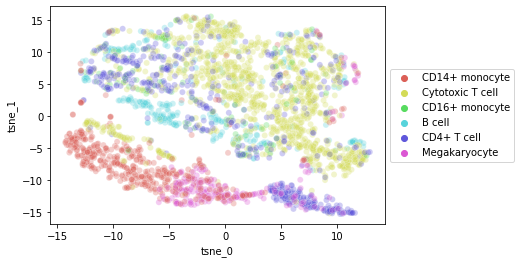

In [60]:
# make a tsne plot of the data
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pbmc1_a_df[expr_col])

plot_df = pd.DataFrame(tsne_results[:,0:2])
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['cell_type'] = pbmc1_a_df["CellType"]

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="cell_type",
    palette=sns.color_palette("hls", pbmc1_a_df.CellType.unique().shape[0]),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# Make pseudobulks

In [61]:
# write out all the methods

# cell type specific pseudobulk
def get_cell_type_sum(in_df, cell_type_id, num_samples):
  cell_df = in_df[in_df.CellType.isin([cell_type_id])]
  cell_sample = cell_df[expr_col]
  cell_sample = cell_sample.sample(n=num_samples, replace=True)
  return cell_sample.sum(axis=0)

# method to generate a proportion vector
def gen_prop_vec_lognormal(len_vector, num_cells):

  rand_vec = np.random.lognormal(5, np.random.uniform(1,3), len_vector) # 1

  rand_vec = np.round((rand_vec/np.sum(rand_vec))*num_cells)
  if(np.sum(rand_vec) != num_cells):
    idx_change = np.argmax(rand_vec)
    rand_vec[idx_change] = rand_vec[idx_change] + (num_cells - np.sum(rand_vec))

  rand_vec = rand_vec.astype(int)
  
  return rand_vec

# method to generate true proportion vector
def true_prop_vec(in_df, num_cells):

  rand_vec = in_df['CellType'].value_counts() / in_df.shape[0]
  rand_vec = np.array(rand_vec)

  rand_vec = np.round(rand_vec*num_cells)
  if(np.sum(rand_vec) != num_cells):
    idx_change = np.argmax(rand_vec)
    rand_vec[idx_change] = rand_vec[idx_change] + (num_cells - np.sum(rand_vec))

  rand_vec = rand_vec.astype(int)
  
  return rand_vec

# total pseudobulk
def make_prop_and_sum(in_df, expr_col, num_samples, num_cells, use_true_prop):
  len_vector = in_df.CellType.unique().shape[0]

  # instantiate the expression and proportion vectors
  total_expr = pd.DataFrame(columns = expr_col)
  total_prop = pd.DataFrame(columns = in_df.CellType.unique())

  # sample specific noise
  sample_noise = np.random.lognormal(0, 0.1, expr_col.shape[0])

  # cell specific noise
  cell_noise = [np.random.lognormal(0, 0.1, expr_col.shape[0]) for i in range(len_vector)]

  # iterate over all the samples we would like to make
  for samp_idx in range(num_samples):
    if samp_idx % 100 == 0:
      print(samp_idx)

    if use_true_prop:
      props_vec = true_prop_vec(in_df, num_cells)
    else:
      props_vec = gen_prop_vec_lognormal(len_vector, num_cells)
    props = pd.DataFrame(props_vec)
    props = props.transpose()
    props.columns = in_df.CellType.unique()
    total_prop = total_prop.append(props)

    sum_over_cells = np.zeros(expr_col.shape[0])


    #iterate over all the cell types
    for cell_idx in range(len_vector):
      cell_type_id = in_df.CellType.unique()[cell_idx]
      num_cell = props_vec[cell_idx]
      ct_sum = get_cell_type_sum(in_df, cell_type_id, num_cell)

      # add noise
      if not use_true_prop:
        ct_sum = np.multiply(ct_sum, cell_noise[cell_idx])
      sum_over_cells = sum_over_cells + ct_sum

    sum_over_cells = pd.DataFrame(sum_over_cells)
    sum_over_cells = sum_over_cells.transpose()
    sum_over_cells.columns = expr_col

    # add sample noise
    if not use_true_prop:
      sum_over_cells = np.multiply(sum_over_cells, sample_noise)

    total_expr = total_expr.append(sum_over_cells)


  return (total_prop, total_expr)



In [62]:
len_vector = pbmc1_a_df.CellType.unique().shape[0]
gen_prop_vec_lognormal(len_vector, 100)

array([18,  5,  7, 20, 17, 33])

In [63]:
# write out the gene ids
gene_out_file = os.path.join(aug_data_path, f"{out_file_id}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )


# simulate different number of cells
num_samples = 1000
for idx in range(len(num_cells_vec)):
  print(f"New Domain {idx}")
  pbmc_rep1_pseudobulk_file = os.path.join(aug_data_path, f"{out_file_id}_pseudo_{idx}.pkl")
  pbmc_rep1_prop_file = os.path.join(aug_data_path, f"{out_file_id}_prop_{idx}.pkl")

  pseudobulk_path = Path(pbmc_rep1_pseudobulk_file)
  prop_path = Path(pbmc_rep1_prop_file)

  if not pseudobulk_path.is_file(): # skip if we already generated it

    # make the pseudobulks
    num_cells = num_cells_vec[idx]
    prop_df, pseudobulks_df = make_prop_and_sum(pbmc1_a_df, 
                                                expr_col, 
                                                num_samples, 
                                                num_cells,
                                                use_true_prop=False)

    # make the proportions instead of cell counts
    prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)

    pickle.dump( prop_df, open( prop_path, "wb" ) )
    pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )


    if not np.all(np.isclose(prop_df.sum(axis=1), 1.)):
        assert False, "Proportions do not sum to 1"



New Domain 0
New Domain 1
New Domain 2
New Domain 3
New Domain 4
New Domain 5
New Domain 6
0
100
200
300
400
500
600
700
800
900
New Domain 7
0
100
200
300
400
500
600
700
800
900
New Domain 8
0
100
200
300
400
500
600
700
800
900
New Domain 9
0
100
200
300
400
500
600
700
800
900
New Domain 10
0
100
200
300
400
500
600
700
800
900
New Domain 11
0
100
200
300
400
500
600
700
800
900


In [64]:

# simulate same number of cells and cell-type proportions
idx = 9999 # this is a tag that its the "true" proportions
pbmc_rep1_pseudobulk_file = os.path.join(aug_data_path, f"{out_file_id}_pseudo_{idx}.pkl")
pbmc_rep1_prop_file = os.path.join(aug_data_path, f"{out_file_id}_prop_{idx}.pkl")

pseudobulk_path = Path(pbmc_rep1_pseudobulk_file)
prop_path = Path(pbmc_rep1_prop_file)

if not pseudobulk_path.is_file(): # skip if we already generated it

  # make the pseudobulks
  prop_df, pseudobulks_df = make_prop_and_sum(pbmc1_a_df, 
                                              expr_col, 
                                              num_samples, 
                                              num_cells_expected,
                                              use_true_prop=True)

  # make the proportions instead of cell counts
  prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)

  pickle.dump( prop_df, open( prop_path, "wb" ) )
  pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

